<a href="https://colab.research.google.com/github/Liesje123/ia/blob/main/TP6_M2_IA_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP N°6 - Réseaux de neurones
## Transfert de style

### Préambule
L’objectif de ce TP est de réaliser un outil de traitement d’images permettant le transfert de
style en utilisant un réseau de neurones convolutifs. Pour cela, nous nous appuierons sur l’API
Keras de Tensorflow. Le but est de réimplémenter la méthode proposée par Leon A. Gatys,
Alexander S. Ecker et Matthias Bethge1 dans leur article disponible ici.
Ici le but est de transférer le style d’une image initiale, souvent une peinture, vers une image
cible. Les résultats obtenus sont sensibles au nombre d’itérations. Les résultats attendus sont
similaires à la figure 1.


In [6]:
!unzip Data.zip

Archive:  Data.zip
   creating: Data/
   creating: Data/style/
  inflating: Data/style/style1.png   
  inflating: Data/style/style2.png   
  inflating: Data/style/style3.png   
  inflating: Data/style/style4.png   
  inflating: Data/style/style5.png   
  inflating: Data/style/style6.png   
   creating: Data/input/
  inflating: Data/input/input1.png   
  inflating: Data/input/input3.png   
  inflating: Data/input/input4.png   
  inflating: Data/input/input5.png   
  inflating: Data/input/input2.png   
   creating: Data/output/
   creating: Data/vgg/
  inflating: Data/vgg/boat.png       
  inflating: Data/vgg/cat.png        
  inflating: Data/vgg/cellphone.png  


In [7]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

## 1 Préparation des données
### 1.1 Préparation des données en entrée

In [8]:
def preprocessImage(image):
  """Preprocess image for VGG."""
  image = image.astype('float')*255
  image = image[:, :, ::-1] #RGB to BGR
  image[:, :, 0] -= 103.939
  image[:, :, 1] -= 116.779
  image[:, :, 2] -= 123.68
  image = np.expand_dims(image, axis=0)
  return image

### 1.2 Préparation des données en sortie

In [23]:
def deprocessImage(image):
  """Deprocess image for VGG."""
  image = np.squeeze(image, axis=0)
  image[:, :, 0] += 103.939
  image[:, :, 1] += 116.779
  image[:, :, 2] += 123.68
  image = image[:, :, ::-1] #RGB to BGR
  image = np.clip(image, 0, 255).astype('uint8')
  return image

## 2 Le réseau VGG
### 2.1 L’architecture


In [10]:
image = plt.imread('Data/vgg/boat.png')
image = preprocessImage(image)
model = tf.keras.applications.vgg16.VGG16(weights='imagenet') # si image pas en 224*224 -> , include_top=False
# model.summary()

553467096/553467096 [==============================] - 4s 0us/step


### 2.2 Test du réseau

In [11]:
predictions = model.predict(image)
label = tf.keras.applications.vgg16.decode_predictions(predictions)
print(label[0][0])

35363/35363 [==============================] - 0s 0us/step
('n04612504', 'yawl', 0.35794142)


=> Testez sur les images fournies dans le dossier « vgg » des ressources. Les résultats sont-ils satisfaisants ?

=> oui : boat = yawl ; cat = tabby (chat tigré) ; cellphone = cellular phone


## 3 Fonctions de pertes

### 3.1 Perte sur le contenu

In [12]:
def contentLoss(baseImageFeatures, resultImageFeatures):
  """"Content loss"""
  return tf.reduce_sum(tf.square(resultImageFeatures - baseImageFeatures))/2

### 3.2 Perte sur le style

In [13]:
def gramMatrix(feature):
  """Gram matrix computation """
  feature = tf.transpose(feature, (2,0,1))
  features = tf.reshape(feature, (tf.shape(feature)[0], -1))
  return tf.matmul(features, tf.transpose(features))

In [14]:
def styleLoss(styleImageFeatures, resultImageFeatures, width, height):
  """Style loss"""
  G = gramMatrix(styleImageFeatures)
  A = gramMatrix(resultImageFeatures)
  size = height*width
  return tf.reduce_sum(tf.square(G - A))/(4*(size**2)*(3**2))

### 3.3 Perte totale

In [20]:
def computeLoss(resultImage, baseImage, styleImage, featuresMapsModel, alpha, beta, width, height):
  """Loss comutation """
  contentLayer = 'block5_conv2'
  styleLayers = ['block1_conv1','block2_conv1','block3_conv1','block4_conv1', 'block5_conv1']
  inputTensor = tf.concat([baseImage, styleImage, resultImage], axis=0)
  features = featuresMapsModel(inputTensor) # Inference
  loss = tf.zeros(shape=())

  # add content loss
  layerFeatures = features[contentLayer]
  baseImageFeatures = layerFeatures[0, :, :, :]
  resultImageFeatures = layerFeatures[2, :, :, :]
  loss += alpha*contentLoss(baseImageFeatures, resultImageFeatures)

  # add style loss
  for layer in styleLayers:
    layerFeatures = features[layer]
    styleImageFeatures = layerFeatures[1, :, :, :]
    resultImageFeatures = layerFeatures[2, :, :, :]
    loss += beta*styleLoss(styleImageFeatures, resultImageFeatures, width, height)
  return loss


## 4 Rétro-propagation


In [16]:
def computeLossAndGradients(resultImage, baseImage, styleImage,featuresMapsModel, alpha, beta, width, height):
  """Loss and gradients computation (compiled)."""
  with tf.GradientTape() as tape:
    loss = computeLoss(resultImage, baseImage, styleImage,
    featuresMapsModel, alpha, beta, width, height)
    gradients = tape.gradient(loss, resultImage)
  return loss, gradients

## 5 Boucle d’apprentissage

In [17]:
# load data
baseImage = preprocessImage(plt.imread('Data/input/input1.png'))
styleImage = preprocessImage(plt.imread('Data/style/style1.png'))
resultImage = tf.Variable(baseImage)
_, heigth, width, _ = baseImage.shape

In [18]:
# build model
model = tf.keras.applications.vgg16.VGG16(weights='imagenet' , include_top=False)
outputs = dict([(layer.name, layer.output) for layer in model.layers])
featuresMapsModel = tf.keras.Model(inputs=model.inputs, outputs=outputs)

58889256/58889256 [==============================] - 0s 0us/step


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


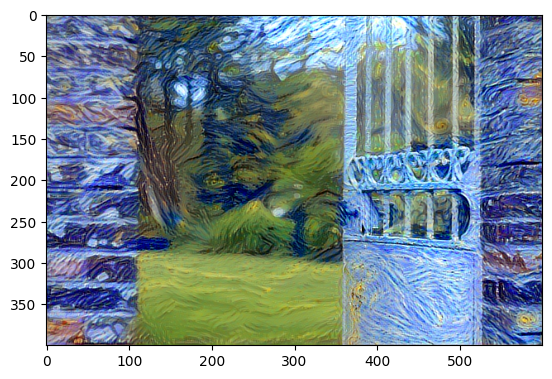

In [25]:
# Learn model
optimizer = tf.keras.optimizers.SGD(
    tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96))

for i in range(100):
  print(i)
  _, gradients = computeLossAndGradients(
      resultImage, baseImage, styleImage, featuresMapsModel,
      1e-8, 2e-5/5, width, heigth)
  optimizer.apply_gradients([(gradients, resultImage)])

plt.imshow(deprocessImage(resultImage.numpy()))